In [1]:
import mitsuba as mi 
mi.set_variant("cuda_ad_rgb")
from PDE2D.Solver import *
from PDE2D.BoundaryShape import *
from PDE2D.Coefficient import *
from PDE2D import GreenSampling
from PDE2D.utils import *

In [2]:
bbox = [[-1.05, -1.05], [1.05, 1.05]]
resolution = [512, 512]
injection_confs = [[0, 10]]
conf_numbers = [UInt32(0)]
origin = [-0.2, -0.3]
radius = 0.2
out_boundary = CircleWithElectrodes(injection_confs = injection_confs, is_delta = True)
in_boundary = CircleShape(name = "inboundary", origin = origin, radius = radius)
shape = BoundaryWithDirichlets(out_boundary, [in_boundary], dirichlet_values = [[0]])
data_holder = DataHolder(shape)
opt_params = ["inboundary.dirichlet.origin", "inboundary.dirichlet.radius"]
wos = WostConstant(data_holder, opt_params = opt_params)

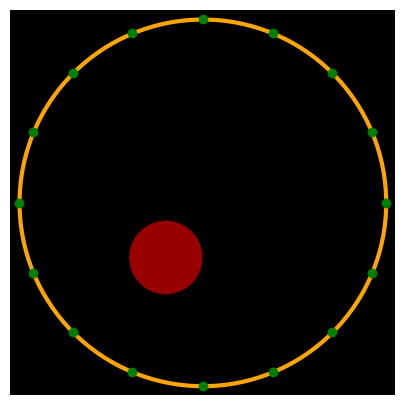

In [3]:
fig, ax = plt.subplots(1,1, figsize = (5,5))
image = shape.sketch_image(ax, bbox, resolution);

In [4]:
res = 64
spp = 25
distance1 = 0.01
distance2 = 0.003
normal_ders1, normal_ders_tex1 = wos.create_normal_derivative(res = res, spp = 2 ** spp, distance = distance1, conf_numbers = conf_numbers)
normal_ders2, normal_ders_tex2 = wos.create_normal_derivative(res = res, spp = 2 ** spp, distance = distance2, conf_numbers = conf_numbers)

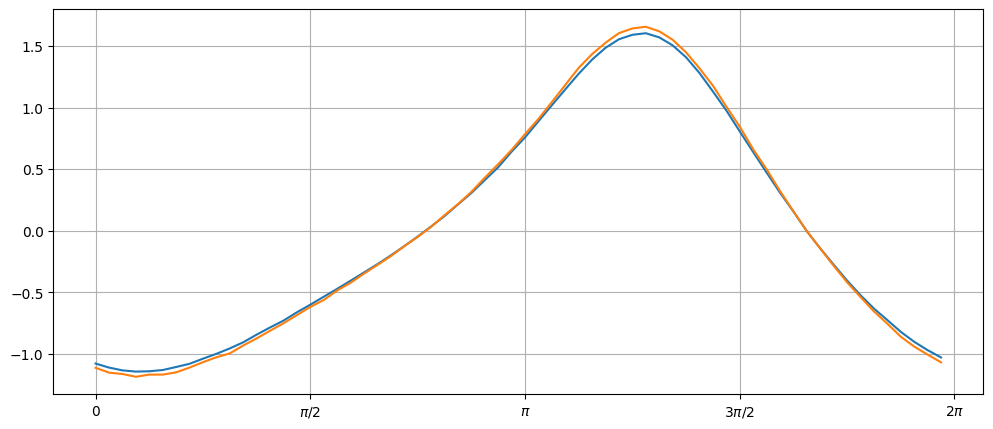

In [5]:
fig, ax = plt.subplots(1,1, figsize = (12,5))
x = np.arange(res)/res * 2 * np.pi
plt.plot(x, normal_ders1.numpy()[0] )
plt.plot(x, normal_ders2.numpy()[0] )
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2 * np.pi])
ax.grid()
ax.set_xticklabels(["0", r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$"]);

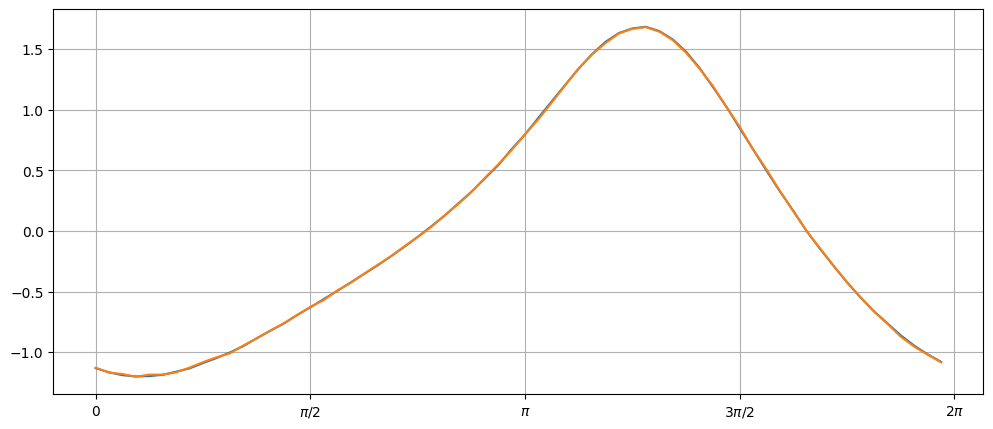

In [6]:
fig, ax = plt.subplots(1,1, figsize = (12,5))
x = np.arange(res)/res * 2 * np.pi
plt.plot(x, normal_ders1.numpy()[0] * (1 + distance1 / radius))
plt.plot(x, normal_ders2.numpy()[0] * (1 + distance2 / radius))
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2 * np.pi])
ax.grid()
ax.set_xticklabels(["0", r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$"]);


In [7]:
res = 64
spp = 22
distance = 0.05
_ = wos.create_normal_derivative(res = res, spp = 2 ** spp, distance = distance1, conf_numbers = conf_numbers)

In [8]:
opt = Adam(lr = 0.1, params = wos.opt_params)
wos.update(opt)

In [9]:
dr.grad_enabled(wos.input.shape.in_boundaries[0].origin)

True

In [10]:
dr.grad_enabled(opt["inboundary.dirichlet.origin"])

True

In [11]:
spe = 2 ** 12
normalization = False
points, active_conf, electrode_nums = out_boundary.create_electrode_points(spe, conf_numbers=conf_numbers)
L, _ = wos.solve(points, active_conf, conf_numbers= conf_numbers, all_inside = True)
el_tensor = create_electrode_result(L, spe, electrode_nums, apply_normalization=normalization)

In [12]:
L, _ = wos.solve(points, active_conf, conf_numbers=conf_numbers, all_inside = True, normal_derivative_dist=distance)
el_tensor = create_electrode_result(L, spe, electrode_nums, apply_normalization=normalization)
# dr.eval(el_tensor)
loss_grad = compute_loss_grad(result = el_tensor)
dL = compute_dL(L = L, loss_grad=loss_grad, spe = spe, electrode_nums=electrode_nums, apply_normalization=normalization)

In [13]:
L, _ = wos.solve(points, active_conf, L_in=L, conf_numbers=conf_numbers, dL =dL, all_inside = True, normal_derivative_dist=distance, mode = dr.ADMode.Backward)

In [14]:
dr.grad(wos.input.shape.in_boundaries[0].radius)

[-0.223956]

In [15]:
dr.grad(wos.input.shape.in_boundaries[0].origin)

[[-0.145536, -0.222191]]